In [1]:
%load_ext autoreload
%autoreload 2

#%config IPCompleter.greedy=True

# Rotation curves

First, imports:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy import units
from pathlib import Path
import os
import astropy.units as u
from astropy.constants import G

import snapshot_obj 
import curve_fit
import dataset_compute

import importlib

In [3]:
importlib.reload(snapshot_obj)
importlib.reload(curve_fit)
importlib.reload(dataset_compute)

<module 'dataset_compute' from '/home/kassiili/Curvaton_Simulations/analysis/dataset_compute.py'>

In [4]:
def compute_rotation_curve2(snapshot,gn,sgn,part_type=[],jump=10):
    # Get centre of potential:
    SGNs = snapshot.get_subhalos("SubGroupNumber")
    GNs = snapshot.get_subhalos("GroupNumber")
    COPs = snapshot.get_subhalos("CentreOfPotential")

    halo_mask = np.logical_and(SGNs == sgn,GNs == gn)
    cop = COPs[halo_mask]
 
    # Get indeces of particles of halo:
    IDs = snapshot.get_subhalos_IDs(part_type=part_type)
    IDs = IDs[halo_mask][0]
    print(len(IDs))
    IDs_from_pd = snapshot.get_particles("ParticleIDs") #,part_type=part_type)
    intersect,i,idxs = np.intersect1d(IDs,IDs_from_pd,return_indices=True,assume_unique=True)

    # Get coordinates and masses of the halo:
    coords = snapshot.get_particles("Coordinates")[idxs]
    mass = snapshot.get_particle_masses()[idxs]
    print(mass.size)
    
    # Calculate distance to centre and cumulative mass:
    r = np.linalg.norm(coords - cop, axis=1)
    sorting = np.argsort(r)
    r = r[sorting]
    cmass = np.cumsum(mass[sorting])
   
    # Clean up:
    mask = r>0; r=r[mask]; cumass=cmass[mask]
    r = r[jump::jump]
    cumass = cumass[jump::jump]
    
    # Compute velocity.
    myG = G.to(u.cm**3 * u.g**-1 * u.s**-2).value
    v_circ = np.sqrt((myG * cumass) / r)

    return r,v_circ

## Get data

In [5]:
# Which halo:
gn = 1; sgn = 0

# Get LCDM data:
LCDM = snapshot_obj.Snapshot("CDM_V1_LR",127)

In [6]:
# Read halo:
fnum = LCDM.file_of_halo(gn,sgn)
SGNs = LCDM.get_subhalos("SubGroupNumber",fnums=[fnum])
GNs = LCDM.get_subhalos("GroupNumber",fnums=[fnum])

vmax = LCDM.get_subhalos("Vmax",fnums=[fnum]) / 100000 
                                                    # cm/s to km/s 
rmax = LCDM.get_subhalos("VmaxRadius",fnums=[fnum]) \
            * u.cm.to(u.kpc)

# Select halo:
halo_mask = np.logical_and(SGNs == sgn,GNs == gn)
vmax = vmax[halo_mask]
rmax = rmax[halo_mask]

In [7]:
# V1kpc:
SGNs = LCDM.get_subhalos("SubGroupNumber")
GNs = LCDM.get_subhalos( "GroupNumber")
halo_mask = np.logical_and(SGNs == sgn,GNs == gn)
v1kpc = LCDM.get_subhalos("V1kpc") 
v1kpc = v1kpc[halo_mask]

In [8]:
r = {}
v_circ = {}
pts = {'gas' : [0], 'dm' : [1], 'stars' : [4], 'BHs' : [5], 'all' : [0,1,4,5]}
#pts = {'gas' : [0], 'dm' : [1], 'stars' : [4], 'BHs' : [5]}
# Read particles:
for key,pt in pts.items():
    print(key)
    r_pt, v_circ_pt = compute_rotation_curve2(LCDM, gn, sgn, part_type=pt)
    print(r_pt.size)
    r[key] = r_pt * u.cm.to(u.kpc)
    v_circ[key] = v_circ_pt * u.cm.to(u.km) 


gas
83932
83932
8393
dm
207858
207858
20785
stars
48096
48096
4809
BHs
40
40
3
all
339926
339926
33992


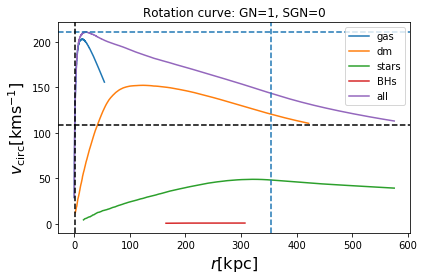

In [9]:
fig, axes = plt.subplots()

# Set axes:
#axes.set_xscale('log')
#axes.set_yscale('log')
#axes.set_xlim(0,50)
#axes.set_ylim(170,220)

# Set labels:
axes.set_xlabel('$r[\mathrm{kpc}]$', fontsize=16)
axes.set_ylabel('$v_{\mathrm{circ}}[\mathrm{kms^{-1}}]$', fontsize=16)

# Galaxy text:
axes.set_title('Rotation curve: GN={}, SGN={}'.format(gn,sgn))

for key in pts.keys():
    axes.plot(r[key], v_circ[key], label=key)
axes.axhline(vmax,linestyle='dashed')
axes.axvline(rmax,linestyle='dashed')
axes.axhline(v1kpc,linestyle='dashed',c='black')
axes.axvline(1,linestyle='dashed',c='black')
    
plt.legend()
plt.tight_layout()


# Save figure:
#
#filename = 'cumulDistByVmax_evol_{}.png'.format(galaxy)
#
#home = os.path.dirname(snapshot_obj.__file__)
#path = os.path.join(home,"Figures")
#
## If the directory does not exist, create it
#if not os.path.exists(path):
#    os.makedirs(path)
#plt.savefig(os.path.join(path,filename), dpi=200)